**Econ691-06 | Hanh Nong**
# <center>ASSIGNMENT 4</center>

In [42]:
#setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sfa
from statsmodels.iolib.summary2 import summary_col
from scipy import stats
import seaborn as sns
from scipy.stats import norm

## PROBLEM 1: Quasi-Experimental Methods, Part I

Hello Fresh is a meal-preparation service that operates in several countries. It sends subscribers the ingredients to cook meals a few times a week. Assume in this stylized problem that Hello Fresh has a single meal plan and operates in the US, Canada, and Australia. It collects feedback from consumers with monthly surveys, scored from 0 through 10. 

Hello Fresh recently pioneered a low-sodium version of its meal plan. It does not have the logistical infrastructure to provide two different meal plans in the same country, but it still wants to understand the effect of the low-sodium plan on satisfaction ratings. It thus rolls out the low-sodium plan in the US only, without making changes in Canada and Australia. Note that this roll-out only occurred at the start of August; until then, all consumers received the regular meal plan. Hello Fresh asks you to use this data to estimate a treatment effect.

The data is in the file data_assignment4_1.csv. The file has 3,000 rows. Each row corresponds to a separate user, for which there are three columns. The first column is the user's country: US, CA (Canada), or AU (Australia). The second column is the month in which the survey took place: one of April, May, June, July, or August (2020). The third column is the outcome, i.e. the user's surveyed satisfaction from 0 through 10. There are exactly 1,000 users from each country.

In [43]:
data1 = pd.read_csv("data_assignment4_1.csv")

In [44]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
country         3000 non-null object
month           3000 non-null object
satisfaction    2951 non-null float64
dtypes: float64(1), object(2)
memory usage: 70.4+ KB


In [45]:
data1.nunique()

country          3
month            5
satisfaction    11
dtype: int64

In [46]:
data1.describe()

,satisfaction
count,2951.000000
mean,5.212131
std,2.259834
min,0.000000
25%,4.000000
50%,5.000000
75%,7.000000
max,10.000000


In [47]:
data1.iloc[np.where(data1['satisfaction'].isnull())[0],].nunique()

country         3
month           5
satisfaction    0
dtype: int64

There are 49 NA values in satisfaction, across 3 countries and 5 months. This is not a large number compared to 3000 observations, ~1.6%. Hence, they can be removed from data.

In [48]:
data1.dropna(inplace = True)
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2951 entries, 0 to 2999
Data columns (total 3 columns):
country         2951 non-null object
month           2951 non-null object
satisfaction    2951 non-null float64
dtypes: float64(1), object(2)
memory usage: 92.2+ KB


In [49]:
#Set up bootstrap function:
def bstr_quasi(data, method, treatment_col, group = ["",""], group_col = ""):
    t_idx = np.where(data[treatment_col] == 1 )[0]
    if method == "event":
        c_idx = np.where(data[treatment_col] == 0)[0]
        index_treatment = np.random.choice(t_idx, replace = True, size = len(t_idx))
        index_control = np.random.choice(c_idx, replace = True, size = len(c_idx))
        sample = pd.concat([data.iloc[index_treatment], 
                            data.iloc[index_control]], 
                           ignore_index=True, sort=False)    
    else:
        c_idx = data.iloc[np.where(data[group_col] == group[0])[0]].drop(t_idx).index        
        index_treatment = np.random.choice(t_idx, replace = True, size = len(t_idx))
        index_control = np.random.choice(c_idx, replace = True, size = len(c_idx))
        index_parallel_group = np.random.choice(np.where(data[group_col] == group[1])[0], 
                                          replace = True, 
                                          size = len(data.iloc[np.where(data[group_col] == group[1])[0]]))
        sample = pd.concat([data.iloc[index_treatment], 
                            data.iloc[index_control], 
                            data.iloc[index_parallel_group]], 
                           ignore_index=True, sort=False)
    return sample

### 1.1. (5 points)
**Using the event study methodology, compute the effect of treatment (along with standard errors). Note any choices you make in determining the length of the pre-treatment period.**

The pre-treatment period is 1 month right before the treatment. After-treatment period is only 1 month, hence, pre-treatment period of 1 month could be more comparable. 

In [50]:
data1['month'].unique()

array(['April', 'May', 'June', 'July', 'August'], dtype=object)

In [51]:
#Create dummy variable
data1['treatment'] = ((data1['country'] ==  "US") & 
                      (data1['month'] == 'August')).astype(int)

#Select period for treatment effect estimation
exp_period = ["July", "August"]
#exp_period = data1['month'].unique()

#Subset data for experimental data
data1_event = data1.iloc[np.where((data1['country'] == "US") & 
                                  (data1['month'].isin(exp_period)))[0],]

In [52]:
#Run bootstrap
bstr1_event = []
for i in range(1000):
    sample = bstr_quasi(data = data1_event, method = "event",
                         treatment_col = "treatment")
    bstr1_event.append(sfa.ols("satisfaction ~ treatment", data = sample)
                       .fit(cov_type='HC1').params[1])

In [53]:
print("Treatment effect, event study method:", round(np.mean(bstr1_event),3))
print("std, event study method:", round(np.std(bstr1_event),3))

Treatment effect, event study method: 0.872
std, event study method: 0.187


### 1.2. (10 points)
**Now, we prepare to do the differences-in-differences analysis. To do so, examine the parallel trends assumption across the US, Canada, and Australia. For which countries does this assumption hold better or worse?**

In parallel trend assumption, we expect the untreated group would behave the same way as treated group if no treatment was applied. So, ideally, the control group should share same pattern in time trend with the treatment group in pre-treatment period. Historical satisfaction of CA & AU is visualized for the period before the treatment as below. Whichever country that has cosistent time trend with US would be control group for diff-if-diff method. 

US's satisfaction changed with moderate magnitude. CA's general time trend is more consistent with US than AU's. CA's satisfaction decreased/increased as US's satisfaction decreased/increased and with a relatively same magnitude over the time. AU's satisfaction is very volatile and did not follow US's general time trend. AU did follow the trend in June and July but with a much higher magnitude than US. Hence, the parallel trend assumption holds better for CA and worse for AU. Thus, CA is used as parallel trend in diff-in-diff method.

In [54]:
data1['country'].unique()

array(['US', 'CA', 'AU'], dtype=object)

In [55]:
#Prepare data for examining parallel trends: Group surveyed satisfaction data by month and by country
data1['mth'] = pd.factorize(data1['month'])[0]
data1_group = data1.groupby(['mth', 'country'])['satisfaction'].mean().unstack(-1)
data1_group.columns = ['AU', 'CA', 'US']
data1_group

,AU,CA,US
mth,,,
0,3.664975,7.165829,5.274112
1,4.101523,6.809278,4.869347
2,3.639175,6.427835,4.587629
3,4.326531,6.800000,4.643216
4,4.040609,6.295918,5.510101


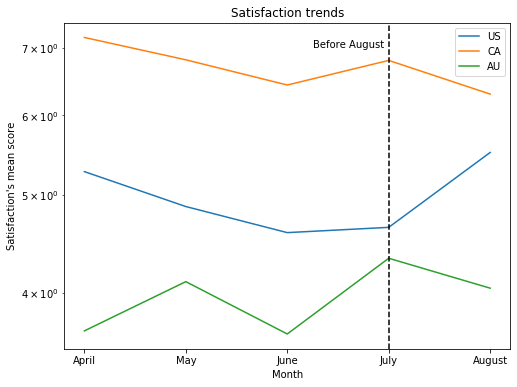

In [56]:
#Plot trend through the time to spot the pattern between countries
plt.figure(figsize = (8, 6))
plt.semilogy(data1_group['US'], label = "US")
plt.semilogy(data1_group['CA'], label = "CA")
plt.semilogy(data1_group['AU'], label = "AU")
plt.axvline( x= 3 ,color='black', ls = "--")
plt.text(x = 2.25, y = 7, s = 'Before August',color = 'black')
plt.title("Satisfaction trends")
plt.xlabel("Month")
plt.ylabel("Satisfaction's mean score")
plt.xticks(data1_group.index, data1['month'].unique())
plt.legend()
plt.show()

### 1.3. (5 points)
**Using the differences-in-differences methodology and your assessment from the previous question, compute the effect of treatment (along with standard errors).**

In [57]:
#Subset data for experimental data
data1_diff = data1.iloc[np.where((data1['month'].isin(exp_period)) & 
                                 (data1['country'] != "AU"))].reset_index(drop = True)

#Dummy variable for time
data1_diff['Aug'] = (data1_diff['month'] == "August").astype(int)

#Dummy variable for country
data1_diff['US'] = (data1_diff['country'] == "US").astype(int)

In [58]:
#Run bootstrap
bstr1_diff = []
for i in range(1000):
    sample = bstr_quasi(data = data1_diff,
                        method = "diff",
                        treatment_col = "treatment", 
                        group = ["US", "CA"],
                        group_col = "country",)
    bstr1_diff.append(sfa.ols("satisfaction ~ treatment + US + Aug",
                                 data = sample)
                         .fit(cov_type='HC1').params[1])

In [59]:
print("Treatment effect, diff-in-diff method:", round(np.mean(bstr1_diff),3))
print("Standard error, diff-in-diff method:", round(np.std(bstr1_diff),3))

Treatment effect, diff-in-diff method: 1.359
Standard error, diff-in-diff method: 0.272


## PROBLEM 2: Quasi-Experimental Methods, Part II

Blue Apron is another meal-preparation company that competes with Hello Fresh, and that operates in the US only. Assume that in this stylized problem, it also used to have a single meal plan; and recently developed a low-sodium plan that it wants to test with consumers. Unlike Hello Fresh, Blue Apron has not run satisfaction surveys in the past, and so cannot rely on historical data. On the plus side and still unlike Hello Fresh, Blue Apron does have the logistical infrastructure to provide two different meal plans in the same country.

Blue Apron does not want to randomize due to the PR risk of consumers receiving low-sodium meals without their consent. As such, it opens an online queue. Blue Apron is able to serve low-sodium meals to the first 10,000 customers in the queue; although it cannot serve such meals to the remaining (who continue to receive their regular meals), as Blue Apron later realizes it does not have enough low-sodium meals. Blue Apron asks you to use this data to estimate a treatment effect.

The data is in the file data_assignment4_2.csv. The file has 30,000 rows. Each row corresponds to a separate user, for which there are four columns. The first column is the user's position in the queue, where NA indicates that the user chose not to sign up for the queue at all. The second column is whether the user received the treatment, i.e. low-sodium meals (indicated by 1), or continued to receive the regular meals (indicated by 0). The third column is the outcome, i.e. the user's surveyed satisfaction from 0 through 10. The fourth column is called "popups" and should be put aside until later in the problem.

In [60]:
data2 = pd.read_csv("data_assignment4_2.csv")

In [61]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
queue           20000 non-null float64
treatment       30000 non-null int64
satisfaction    30000 non-null int64
popups          30000 non-null int64
dtypes: float64(1), int64(3)
memory usage: 937.6 KB


In [62]:
data2.nunique()

queue           20000
treatment           2
satisfaction       11
popups              2
dtype: int64

In [63]:
data2.describe()

,queue,treatment,satisfaction,popups
count,20000.000000,30000.000000,30000.000000,30000.000000
mean,10000.500000,0.333333,4.584867,0.500867
std,5773.647028,0.471412,1.492963,0.500008
min,1.000000,0.000000,0.000000,0.000000
25%,5000.750000,0.000000,4.000000,0.000000
50%,10000.500000,0.000000,5.000000,1.000000
75%,15000.250000,1.000000,6.000000,1.000000
max,20000.000000,1.000000,10.000000,1.000000


In [64]:
data2.query("queue <= 10000")['treatment'].sum()

10000

In [65]:
#turn NA to 0 for easy processing in other step.
data2['queue'] = data2['queue'].fillna(0)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
queue           30000 non-null float64
treatment       30000 non-null int64
satisfaction    30000 non-null int64
popups          30000 non-null int64
dtypes: float64(1), int64(3)
memory usage: 937.6 KB


### 2.1. (5 points) 
**Why can we not regress satisfaction on treatment for a valid treatment effect? Explain this in concrete language relevant to this scenario.**

The treatment is not randomized. Those who queued for low-sodium meal plan are likely to be conscious about diet and are more likely to be satisfied with the low-sodium meal plan. We will have selection bias if we regress on treatment only.

### 2.2.
**You decide to pursue a regression discontinuity design, in which you analyze consumers around
the queue cutoff of 10,000.**

**2.2(a) (5 points) Using the same concrete language relevant to this scenario, why can we compare consumers' outcomes just above and below the cutoff to get a valid treatment effect? In your answer, note any assumptions and whether you believe them to satisfied. (You do not need to formally test the assumptions.)**

Those who are right after the cut-off are likely to care about diet as much as those who are eligible for the low-sodium meal plan. They just miss the spot by a few queue. In other words, they are not different from those who are right before them. In this method, two assumptions should be satisfied:

Assumption 1: the model selected for the regression is linear. The assumption here is this model specification is correctly chosen. Satisfaction should have constant slope with respect to queue. This assumption is believed to be satisfied as the position in queue does not indicate a lower or higher satisfaction. Without treatment, the relationship between satisfaction and a person who queued at 3000th vs a person who queued at 15000th should be the same. This assumption should be satisfied. If we put treatment aside, whatever a customer's position is in the line, they receive the same type of meal-plan, with same level of quality.

Assumption 2: satisfaction is continous around the cut-off. Queing for low-sodium plan is voluntary opt-in. There is no reason for a person who strategically queues near the cut-off to be dropped out. It also does not make sense that a person queues near the cut-off to increase the chance of securing a spot. Moreover, at the time of the queue, the assignment rule was unknown as Blue Apron only recognized it could not serve low-sodium meal plan to all queues afterwards.

**2.2(b) (5 points) Using the regression discontinuity methodology and all data, estimate the treatment effect (along with standard errors).**

In [82]:
reg2_2b = sfa.ols("satisfaction ~ queue + treatment", 
                  data = data2.iloc[np.where(data2['queue']>0)[0]]).fit(cov_type='HC1')
print("effect, discontinuity method on all data:", round(reg2_2b.params[2],3))
print("std, discontinuity method on all data:", round(reg2_2b.bse[2],3))

effect, discontinuity method on all data: 1.218
std, discontinuity method on all data: 0.039


In [84]:
bstr_discont_all = []
for i in range(1000):
    sample = bstr_quasi(data = data2.iloc[np.where(data2['queue']>0)[0]], 
                        method = "event", 
                        treatment_col = "treatment")
    #sample['bstr_queue'] = np.arange(start = 1, stop = 20001)
    reg_bstr_discont = sfa.ols("satisfaction ~ queue + treatment", 
                               data = sample).fit(cov_type='HC1')
    bstr_discont_all.append(reg_bstr_discont.params[2])
print("std, discontinuity method on all data:", round(np.std(bstr_discont_all),3))

std, discontinuity method on all data: 0.039


**2.2(c) (5 points) Use the same methodology but restrict to data within a narrow band around the cutoff: those with queue places between 9,000 and 11,000. Why might the result differ, and which result do you trust more?**

As we use much less data for this method compared to 2.2b, we can expect increase in variance but lower bias. Hence, the result differs from using all data.

I would trust this result more than result on all data. Reasons are:
- Those who queue closed to each other could share the same level of interest in low-sodium meal plans than those who queue very far away from the cut-off (assuming that the window for queueing last for a period of time). In short, the later a person get in line, the less excited/willing that person is about the low-sodium plan.
- As we use only a portion of data that clusters around the cut-off, it's less likely that our assumption for the model specification violated, i.e we are more likely to guarantee linear function for our model.
- The variance in this result increased, but not to the level that we would doubt our estimated effect, and since our result will be less biased, the bias-variance trade-off is still somewhat balanced. 

In [85]:
data2_2c = data2.iloc[np.where((data2['queue'] >= 9000) & (data2['queue'] <= 11000))[0]]
reg2_2c = sfa.ols("satisfaction ~ queue + treatment", 
                  data = data2_2c).fit(cov_type='HC1')
print("effect, discontinuity method on narrow band:", round(reg2_2c.params[2],3))
print("std, discontinuity method on narrow band:", round(reg2_2c.bse[2],3))

effect, discontinuity method on narrow band: 1.003
std, discontinuity method on narrow band: 0.123


In [86]:
bstr_discont_restricted = []
for i in range(1000):
    sample = bstr_quasi(data = data2_2c, 
                        method = "event", 
                        treatment_col = "treatment")
    #sample['bstr_queue'] = np.arange(start = 1, stop = 20001)
    reg_bstr_discont = sfa.ols("satisfaction ~ queue + treatment", 
                               data = sample).fit(cov_type='HC1')
    bstr_discont_restricted.append(reg_bstr_discont.params[2])
print("std, discontinuity method on narrow band:", 
      round(np.std(bstr_discont_restricted),3))

std, discontinuity method on narrow band: 0.12


### 2.3.
An engineering team at Blue Apron tells you that they actually were running a separate experiment over this timeframe. Specifically, they were running pop-ups for some users, which informed them about new developments at Blue Apron; and some pop-ups were indeed related to these low-sodium meals and the queue for them. This is the fourth column - "popups" - which tells if you users were receiving these pop-ups (indicated by 1) or not (indicated by 0). You decide to pursue an instrumental variables approach, in which pop-ups are the instrument.

**2.3(a) (10 points) Using the same concrete language relevant to this scenario, why might pop-ups be a valid instrument for this problem? In your answer, note any assumptions and whether you believe them to satisfied.**

Assumption 1 - Relevance: 
People who see pop-ups might be more likely to be better informed about the queue and hence, queue for the treatment. Pop-ups therefore drive the queue/treatment and consequently drive the satisfaction. Since pop-ups can affect treatment, it is a good candidate to be instrumental variable.

Assumption 2 - Exclusion: 
Pop-ups can only affect satisfaction through treatment. For the treatment group, the only way to get low-sodium mealplan is through treatment which is applied for the first 10,000 people. If a person saw pop-ups but didn't sign-up then he couldn't get into the treatment group. There is no information about how pop-ups was implemented, but since it was implemented by a different team without knowing about the assignment of treatment, we can assume pop-ups were random and did not strategically target a group of users. Hence, it should not affect satisfaction through other pathway such as the users' characteristics/opinion about diet.

**2.3(b) (10 points) Using the instrumental variables methodology, estimate the treatment effect.**

In [87]:
#Regression, stage 1
reg2_3b_popups = sfa.ols("treatment ~ popups", data = data2).fit(cov_type='HC1')
data2['treatmentfit'] = reg2_3b_popups.predict(data2['popups'])
print(reg2_3b_popups.summary())

                            OLS Regression Results                            
Dep. Variable:              treatment   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     6543.
Date:                Mon, 28 Sep 2020   Prob (F-statistic):               0.00
Time:                        18:09:53   Log-Likelihood:                -17044.
No. Observations:               30000   AIC:                         3.409e+04
Df Residuals:                   29998   BIC:                         3.411e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5333      0.004    130.793      0.0

In [88]:
#Regression, stage 2
reg2_3b_satisfaction = sfa.ols("satisfaction ~ treatmentfit", 
                               data = data2).fit(cov_type='HC1')
print("Effect, IV stage 2:", round(reg2_3b_satisfaction.params[1],3))

Effect, IV stage 2: 0.992


**2.3(c) (5 points) Using the bootstrap, compute the standard errors of your treatment effect.**

Bootstrap approach: there should be exactly 10,000 units in treatment group & the remaining 20,000 units in control group. This approach is similar to event study method in question 1.

In [89]:
bstr_IV = []
for i in range(1000):
    sample = bstr_quasi(data = data2, method = "event", treatment_col = "treatment")
    reg_bstr_popups = sfa.ols("treatment ~ popups", 
                              data = sample).fit(cov_type='HC1')
    sample['treatmentfit'] = reg_bstr_popups.predict(sample['popups'])
    reg_bstr_satisfaction = sfa.ols("satisfaction ~ treatmentfit", 
                                    data = sample).fit(cov_type='HC1')
    bstr_IV.append(reg_bstr_satisfaction.params[1])
print("std, IV method:", round(np.std(bstr_IV),3))

std, IV method: 0.047


## PROBLEM 3: STREAMING BOOTSTRAP

**(25 points)**

Write a function that can compute the standard errors for the mean of a data series via 1000 bootstrapped iterations. Assume that the data is provided in batches, and each batch must be deleted before the next batch is provided. Test the function on a dataset that comes in five separate batches, where each batch has 100,000 observations randomly and uniformly distributed
from 30 to 50; and report the standard error.

Hint: the function to generate random Poisson values is numpy.random.poisson(lambda, n) in Python and rpois(n, lambda) in R.

In [80]:
def bstr_streamMean(batch_num, iteration_num, func, **kwargs):
    #initiate rolling sum & count of observations across iterations
    roll = np.zeros((iteration_num,2)) 
    
    for b in range(batch_num):    
        batch_data = func(**kwargs) #generate a batch
        for i in range(iteration_num):        
            #draw number of appearance for each observation
            poiss = np.random.poisson(1, len(batch_data)) 
            
            bstr = np.repeat(batch_data, poiss) #create sample
            
            #roll sum and count at each iteration
            roll[i,0] += np.sum(bstr)
            roll[i,1] += len(bstr)
    
    bstr_std = np.std(roll[:,0]/roll[:,1])
    return bstr_std

#Test on dataset
bstr_std = bstr_streamMean(batch_num = 5, iteration_num = 1000, 
                           func = np.random.uniform, low = 30, high = 50, size = 100000)

#Print std of streaming bootstrap
print("std of streaming bootstrap:",round(bstr_std,3))

std of streaming bootstrap: 0.008


When bootstrap on non-streaming data (as below), the std of bootstrap mean is almost the same as the std when using the function above

In [79]:
#Test on non-streaming data
data_series = []
for b in range(5): data_series.append(np.random.uniform(30, 50, 100000))
data_series = np.concatenate(data_series)

sampleMean = []
for i in range(1000):
    sample = np.random.choice(data_series, replace = True, size = len(data_series))
    sampleMean.append(np.mean(sample))
print("std of non-streaming bootstrap mean:", round(np.std(sampleMean),3))  

std of non-streaming bootstrap mean: 0.008
